# Face Recognition Project

## 1 Import dataset: 5 Celebrities

In [ ]:
import zipfile
import os

In [ ]:
!gdown 1YI5ElVwG3tSY5QdqnL3z-X8RN9QVtWZM # link to download the 5 celeb zip file

Downloading...
From: https://drive.google.com/uc?id=1YI5ElVwG3tSY5QdqnL3z-X8RN9QVtWZM
To: /content/archive.zip
100% 5.28M/5.28M [00:00<00:00, 253MB/s]


In [ ]:
# extract the zio file
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [ ]:
!gdown 1QhtX9N2jAgkp46B6jULOcJjAXkVbahL7

Downloading...
From: https://drive.google.com/uc?id=1QhtX9N2jAgkp46B6jULOcJjAXkVbahL7
To: /content/10_classes_pins_dataset.zip
100% 46.8M/46.8M [00:01<00:00, 43.9MB/s]


## 2. Preparing training and validation set

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers, models, applications
import tensorflow as tf

In [ ]:
train_dir = os.path.join(os.getcwd(), 'train')
val_dir = os.path.join(os.getcwd(), 'val')

In [ ]:
batch_size = 4
target_shape = (160, 160)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0,
  seed=123,
  image_size=target_shape,
  batch_size=batch_size)

Found 93 files belonging to 5 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  validation_split=0,
  seed=123,
  image_size=target_shape,
  batch_size=batch_size)

Found 25 files belonging to 5 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

## 3. Building model with ResNet50 as base model

### 3.1 Data augmentation

In [ ]:
class RandomColorDistortion(tf.keras.layers.Layer):
  def __init__(self, contrast_range=[0.75, 1.25],
               brightness_delta=[-0.1, 0.1], **kwargs):
    super(RandomColorDistortion, self).__init__(**kwargs)
    self.contrast_range = contrast_range
    self.brightness_delta = brightness_delta

  def call(self, images, training=False):
    if not training:
      return images
    contrast = np.random.uniform(
    self.contrast_range[0], self.contrast_range[1])
    brightness = np.random.uniform(
    self.brightness_delta[0], self.brightness_delta[1])



    images = tf.image.adjust_contrast(images, contrast)
    images = tf.image.adjust_brightness(images, brightness)
    images = tf.clip_by_value(images, 0, 255)
    return images

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  RandomColorDistortion(name='random_contrast_brightness/none'),
]) # random horizontal flip, random rotation of 0.1 (36 degrees), and random contrast and brightness distortion

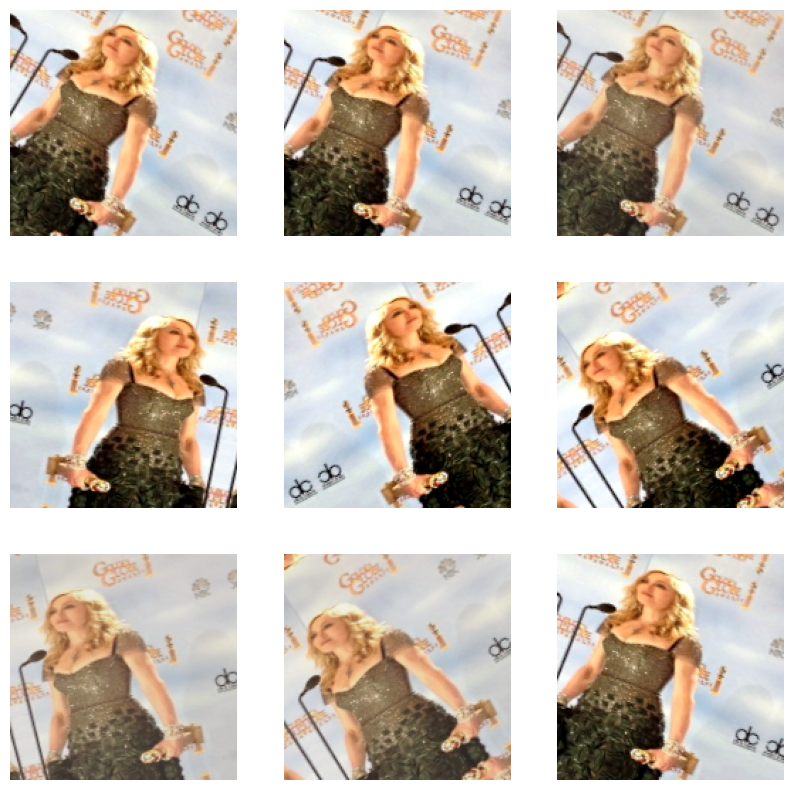

In [ ]:
# visualization of data augmentation
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 3.2 Preprocessing inputs

In [ ]:
preprocess_input = applications.resnet50.preprocess_input

### 3.3 Base model


In [ ]:
base_model = applications.resnet50.ResNet50(weights="imagenet",
                             input_shape=target_shape + (3,),
                             include_top=False)

# you can choose one of the options below: fine-tuning or He random weights initialization.

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Fine-tuning of ResNet50

In [ ]:
# the following commented lines are fine tuning
trainable = False
number_of_layer=0
for layer in base_model.layers:
    number_of_layer+=1
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

He Initialization

In [ ]:
# this is He initialization of the weights
init = tf.keras.initializers.HeUniform(seed=123) # GlorotUniform() is also a good choice, feel free to explore
for w in base_model.trainable_variables:
    w.assign(init(w.shape))

### Assemble layers

In [ ]:
def make_model(input_shape,
               classes,
               base_model:tf.keras.Model,
               preprocess_input,
               augmentation_layer=None,
               dropout_rate=0.2):
  """
  function for returning a model
  base_model: a pretrained model from tf.keras.applications API
  input_preprocess: input preporocessing layer that comes with base_model
  """
  inputs = tf.keras.Input(shape=input_shape + (3,))
  if augmentation_layer:
    x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(classes,
                        activation=tf.keras.activations.softmax)(x)
  return tf.keras.Model(inputs, outputs)


In [ ]:
model = make_model(input_shape=target_shape,
                   classes=len(class_names),
                   base_model=base_model,
                   preprocess_input=preprocess_input,
                   augmentation_layer=data_augmentation,
                   dropout_rate=0) # with 5 celeb, training result is awful with dropout

In [ ]:
model.summary()

### Choosing optimizers

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Create callbacks to stop training when target goal is reached

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        acc = logs['accuracy']
        if val_acc >= 0.92:
            self.model.stop_training = True
            print("goal reached\n")


### You can skip the following cells to use trained weights, otherwise go ahead

In [ ]:
epochs=30
customCallback = CustomCallback()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[customCallback]
)

Epoch 1/30
24/24 [==============================] - 8s 77ms/step - loss: 1.4176 - accuracy: 0.5269 - val_loss: 9.7808 - val_accuracy: 0.5600
Epoch 2/30
24/24 [==============================] - 1s 35ms/step - loss: 1.0015 - accuracy: 0.7527 - val_loss: 8.5217 - val_accuracy: 0.5600
Epoch 3/30
24/24 [==============================] - 1s 30ms/step - loss: 0.4925 - accuracy: 0.8280 - val_loss: 3.1823 - val_accuracy: 0.6400
Epoch 4/30
24/24 [==============================] - 1s 30ms/step - loss: 0.3591 - accuracy: 0.8495 - val_loss: 5.5815 - val_accuracy: 0.4800
Epoch 5/30
24/24 [==============================] - 1s 33ms/step - loss: 0.2539 - accuracy: 0.9140 - val_loss: 1.7588 - val_accuracy: 0.6800
Epoch 6/30
24/24 [==============================] - 1s 35ms/step - loss: 0.1393 - accuracy: 0.9462 - val_loss: 1.1958 - val_accuracy: 0.7200
Epoch 7/30
24/24 [==============================] - 1s 49ms/step - loss: 0.0810 - accuracy: 0.9892 - val_loss: 0.8947 - val_accuracy: 0.8400
Epoch 8/30
24

In [ ]:
# saving the training result as csv file if you wish
import pandas as pd

pd.DataFrame(history.history).to_csv('resnet50_finetuning_nodropout_5celeb.csv')

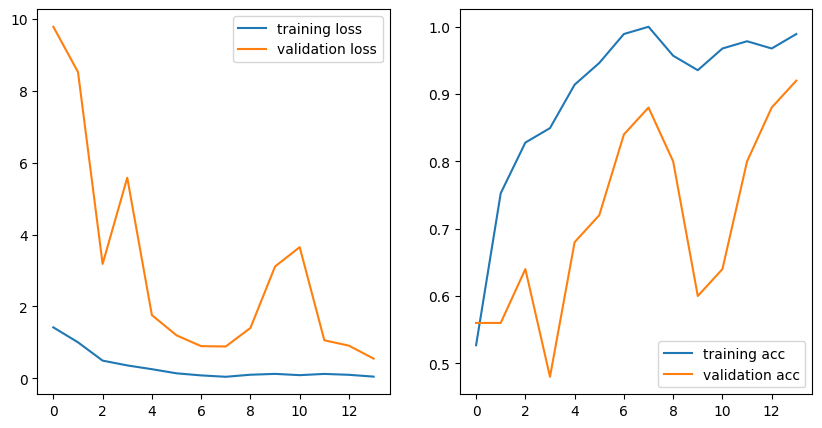

In [ ]:
# visualize training result
import matplotlib.pyplot as plt


training_loss, training_acc = history.history['loss'], history.history['accuracy']
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(training_loss, label='training loss')
ax[0].plot(val_loss, label='validation loss')
ax[0].legend()

ax[1].plot(training_acc, label='training acc')
ax[1].plot(val_acc, label='validation acc')
ax[1].legend()

After training, you can save your weights with the following cells

In [ ]:
model.save_weights('./folder/file_name') # save in a new folder/file_name as you wish

In [ ]:
!tar -czvf weights_resnet50_5celeb_val92.tar resnet50_5celeb_val92/

resnet50_5celeb_val92/
resnet50_5celeb_val92/val_acc_0.92.index
resnet50_5celeb_val92/val_acc_0.92.data-00000-of-00001
resnet50_5celeb_val92/checkpoint


### download the pretrained weights below

In [ ]:
!gdown 1SqFe_k3QhVky5GuZ8W87TLJpZHKnzSTv

Downloading...
From: https://drive.google.com/uc?id=1SqFe_k3QhVky5GuZ8W87TLJpZHKnzSTv
To: /content/weights_resnet50_5celeb_val92.tar
100% 156M/156M [00:00<00:00, 184MB/s]


In [ ]:
!tar -xf weights_resnet50_5celeb_val92.tar

In [ ]:
model.load_weights('./resnet50_5celeb_val92/val_acc_0.92')

In [ ]:
model.evaluate(train_ds) # remember to compile the model first

24/24 [==============================] - 11s 39ms/step - loss: 0.0978 - accuracy: 0.9785


[0.09781037271022797, 0.9784946441650391]

In [ ]:
model.evaluate(val_ds)

7/7 [==============================] - 0s 24ms/step - loss: 0.5481 - accuracy: 0.9200


[0.548137903213501, 0.9200000166893005]

### For the next cells, upload your own images to play with. Have fun

In [ ]:
img_path = 'mindy_kaling_difficult.jpg' #upload your images to test model performance with unseen examples

In [ ]:
import PIL

def predict_and_show(img_path):
  '''
  function to visualize an image and model prediction
  Also returns predictions as list of confidence scores
  '''

  plt.imshow(PIL.Image.open(img_path))

  img = tf.keras.utils.load_img(
    img_path, target_size=target_shape)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model(img_array, training=False)
  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
  )
  return predictions


This image most likely belongs to jerry_seinfeld with a 51.88 percent confidence.


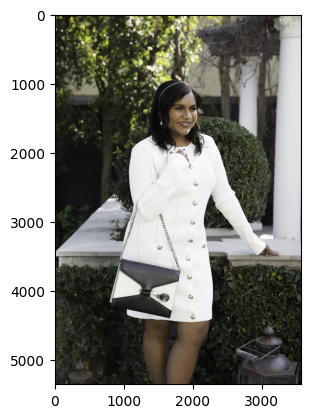

In [ ]:
predictions = predict_and_show(img_path)

In [ ]:
tf.reduce_sum(predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>